## Automated Speaker Verification - A Study in Deep Neural Networks and Transfer Learning 

### Abstract ###
*"Identity theft is not a joke" - Dwight Shrute, The Office*

As the world rapidly shifts towards a technological landscape, the need to protect our online identity becomes more and more imperative. Engineers have tackled this challenge through facial and fingerprint detection, although the ability to authenticate an individual based on a small sample of their voice will completely transform this space. While security can never be guaranteed, speaker verification will add significantly more resistance to anyone attempting to steal another person's identity, and will increase the confidence of the general population in the safety of their identities. Further, considering the recent major advancements in virtual reality, speaker verification and by extension speech recognition will have a substantial influence on our everyday lives, whether it be 40, 20, or even 10 years from now. Hence, our team decided to explore this space, deepening our understanding of neural style transfer through comparing past state-of-the-art TDNN models with the more accurate ECAPA-TDNN model. 

### Introduction ###
Till recently, x-vectors have provided state-of-the-art solutions for speaker verification tasks. Usually, the networks are trained on a speaker identification tasks. Then, after convergence, speaker embeddings can be extracted from the penultimate layer to characterise a speaker in a recording. Speaker verification can thus be accomplished by comparing two embeddings with a simple cosine distance measurement. The rising popularity of the x-vector system has led to major architectural improvements and optimised performancees over the initial approach. Adding residual connections between the frame-level layers has shown to enhance embeddings, with the added benefit of enabling the back-propagation algorithm to converge quicker and avoid the vanishing gradients problem. The statistics pooling layer in the x-vector system projects a variable-length input into a fixed length by gathering information about hidden node activations across time. A temporal self-attention system is often added to this pooling layer which allows the network to focus on frames it deems important, or alternatively, can be interpreseted as a Voice Activity Detection (VAD) prepossessing step to detec irrelevant non-speech frames. Our model expands on this through including enhancements to the TDNN architecture and statistics pooling layer. Namely, this model implements channel and context dependent statistics pooling and adds a multi-layer feature aggregation and summation will significantly increase the accuracy most speaker verification tasks. The final section will conclude with a brief overview of our findings. df

#### Requirements

To activate a virtual environment, run

```shell
python3 -m venv env
source env/bin/activate
```

To install the required python packages, run

```shell
pip install -r requirements.txt
```

### Transfer Learning

The DNN is trained to classify speakers using a training set of speech recorded from a large number of training speakers. (Talk about Vox-Celeb dataset). To leverage feature representations from the pretrained model on the large dataset, speech recorded from each set of enrollment speakers is passed as input to the trained DNN. This enables the computations of deeper hidden features for each speaker in the enrollment set, which are then averaged to generate a compact deep embedding associated with that speaker.   

### Zero-Shot Learning ###
Our model is able to recognise unseen phonemes in the target language [Not sure if our model does this?]


### Data Preparation

Our pretrained model is trained on audio files collected from the VoxCeleb1 + VoxCeleb2 dataset, consisting of speech samples from over 7000 different speakers of a wide range of ethnicities, accents, professions and ages ([SOURCE](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/)). Achieves an accuracy of approximately 98-99%.

### Network Architecture

- Network Architecture (ECAPA-TDNN architecture) (See [here](https://arxiv.org/pdf/2005.07143.pdf))
    - Channel- and context-dependent attention mechanism
    - Multi-layer Feature Aggregation (MFA)
    - AAMsoftmax loss

### Model used: ECAPA-TDNN ###

<center><img src="images/model.jpg" style="width: 250px;"/></center>
<p style="text-align: center">
    <b>Block diagram of the ECAPA-TDNN model</b>
</p>

#### How the model works ####
Initially the model searches for all the .wav files in the specified data folder and randomly splits them into 80% for training, 10% for validation and 10% for testing purposes. The model then begins to train the network on the 80% of training data it receives through applying data preprocesing and augmentation. A Voice Activity Detection (VAD) preprocesisng step is used to detect irrelevant non-speech frames, and the augmentation is run through varying the speeds of the spoken sample [see 3.2.2 Data Augmentation]. Once the data is preprocessed and augmentation is applied, the model starts to learn the new speaker, adjusting the weights and biases respectively. For this, we apply 1024 channels in the convolutional frame layers. The dimension of the bottleneck in the attention module is set to 128, and the number of nodes in the final fully connected layer is 192. The final channel represents the number of classes the embedding could fall under, which after applying the cosine distance similarity operation can be used to provide an accurate estimate of whether the two speakers are identical or not.


#### Model Improvement 1: Statistical Pooling [channel-dependent attentive statistics pooling] ####
Neural networks are known to learn heirarchical structures with each layer operating on a different level of complexity. In the ECAPA-TDNN model, features are aggregated and propagated at different hierarchical levels to produce better results. The statistics pooling module is improved with channel-dependent frame attention, enabling the network to focus on different subsets of frames in each channel statistics estimation. The frames that it does focus on depends on which frames it deems important, which is achieved through the following attention mechanism:


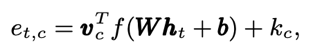

In [ ]:
from IPython.display import Image
Image("../images/attentionMechanism.png")

The scalar score is then normalised [see Normalisation] over all frames by applying the softmax function channel-wise accross time. 

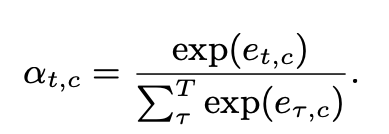

In [ ]:
from IPython.display import Image
Image("../images/softmax.png")

The weighted mean vector and channel component are then constructed as follows:

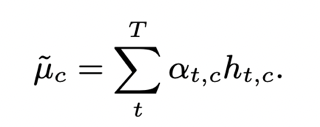

In [ ]:
from IPython.display import Image
Image("../images/weightedMean.png")

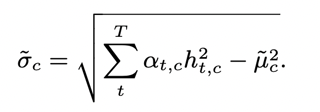

In [ ]:
from IPython.display import Image
Image("../images/channel.png")

#### Model Improvement 2: Multi-layer Feature Aggregation (MFA) ####
In the original x-vector system that our model is based off, only the final frame-layer is used for calculating the pooled statistics, although recent evidence shows that the more shallow and extensive feature maps often contribute to the most robust speaker embeddings. Hence we use all the frames to calculate the final pooled statistsics (Multi-layer Feature Aggregation). For each frame, our system concatenates the output feature maps of all the SE-Res2Blocks. Once all the feature maps are concatenated, a dense layer processes the result and generates the features for attentive statistics pooling. 

### Training a Speech Diarisation model

In [ ]:
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from user_data_prepare import prepare_user_data
from speaker_verif.custom_train import SpkIdBrain, dataio_prep

### Hyperparameters

In [ ]:
# pretrain folders:
pretrained_path: speechbrain/spkrec-ecapa-voxceleb

# Training Parameters
lr: 0.001
lr_final: 0.0001
sample_rate: 16000
number_of_epochs: 35
batch_size: 32

# Feature parameters
n_mels: 80
left_frames: 0
right_frames: 0
deltas: False

out_n_neurons: 50 # maximum number of speakers
emb_dim: 512 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

##### Environmental Corruption

In [ ]:
# Added noise and reverb come from OpenRIR dataset, automatically
# downloaded and prepared with this Environmental Corruption class.
env_corrupt: !new:speechbrain.lobes.augment.EnvCorrupt
    openrir_folder: !ref <data_folder>
    babble_prob: 0.0
    reverb_prob: 0.0
    noise_prob: 1.0
    noise_snr_low: 0
    noise_snr_high: 15

##### Data Augmentation

In [ ]:
# Adds speech change + time and frequency dropouts (time-domain implementation)
# # A small speed change help to improve the performance of speaker-id as well.
augmentation: !new:speechbrain.lobes.augment.TimeDomainSpecAugment
    sample_rate: !ref <sample_rate>
    speeds: [90, 95, 100, 105, 110]

##### Normalisation

In [ ]:
# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

##### Model parameters

In [ ]:
# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>
    left_frames: !ref <left_frames>
    right_frames: !ref <right_frames>
    deltas: !ref <deltas>

embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    channels: [1024, 1024, 1024, 1024, 3072]
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: 128
    lin_neurons: 192

classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: 192
    out_neurons: !ref <out_n_neurons>

### Speechbrain: A Pytorch-based Speech Toolkit

Add some text here...

In [ ]:
# Path to model hyperparameters file
hparams_file = "speaker_verif/custom_train.yaml"

# Initialize ddp (useful only for multi-GPU DDP training).
sb.utils.distributed.ddp_init_group(run_opts)

# Load hyperparameters file with command-line overrides.
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, overrides)

# Create experiment directory
sb.create_experiment_directory(
    experiment_directory=hparams["output_folder"],
    hyperparams_to_save=hparams_file,
    overrides=overrides,
)

# Data preparation, to be run on only one process.
sb.utils.distributed.run_on_main(
    prepare_user_data,
    kwargs={
        "data_folder": hparams["data_folder"],
        "save_json_train": hparams["train_annotation"],
        "save_json_valid": hparams["valid_annotation"],
        "save_json_test": hparams["test_annotation"],
        "split_ratio": [80, 10, 10],
    },
)

# Load the pretrained model
if "pretrainer" in hparams:
    hparams["pretrainer"].collect_files()
    hparams["pretrainer"].load_collected(device=run_opts["device"])
else:
    print("No pretrained model found, training from scratch.")
    
# Create dataset objects "train", "valid", and "test".
datasets = dataio_prep(hparams)

# Initialize the Brain object to prepare for mask training.
spk_id_brain = SpkIdBrain(
    modules=hparams["modules"],
    opt_class=hparams["opt_class"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)   

# The `fit()` method iterates the training loop, calling the methods
# necessary to update the parameters of the model. Since all objects
# with changing state are managed by the Checkpointer, training can be
# stopped at any point, and will be resumed on next call.
spk_id_brain.fit(
    epoch_counter=spk_id_brain.hparams.epoch_counter,
    train_set=datasets["train"],
    valid_set=datasets["valid"],
    train_loader_kwargs=hparams["dataloader_options"],
    valid_loader_kwargs=hparams["dataloader_options"],
)

# Load the best checkpoint for evaluation
test_stats = spk_id_brain.evaluate(
    test_set=datasets["test"],
    min_key="error",
    test_loader_kwargs=hparams["dataloader_options"],
)

### Verification through Inference

To verify the identity of an unknown speaker, a test utterance of the unknown speaker is passed as input to the trained DNN. A compact deep embedding associated with the unknown speaker is generated and compared with the compact deep embeddings associated with each of the enrollment speakers through calculation of Cosine Distance Similarity. (Talk about Cosine Distance - include brief background?). The distance between the compared compact deep embeddings corresponds to the likelihood that the unknown speaker belongs to the set of enrolled speakers. 

In [ ]:
# Imports for inference

import os
import shutil
import glob
from random import shuffle
from torch.nn import CosineSimilarity 
from torchaudio import load as load_signal
from speechbrain.pretrained import EncoderClassifier

To enable easy accessibility to the most recently trained model, we first move it to the "content/best_model" path along with associated hyperparameters and class labels. 

In [ ]:
src_path = "results/speaker_id/1986/save/"  # Path to trained network checkpoints
dest_path = "content/best_model/"           # Path to store most recently trained model information 

if os.path.exists(dest_path):
    shutil.rmtree(dest_path)

os.mkdir(dest_path)
shutil.copy2("./hparams_inference.yaml", dest_path)
shutil.copy2(src_path + "label_encoder.txt", dest_path)
ckpt_files = glob.glob(src_path + "CKPT*")
if not ckpt_files:
    print("No trained checkpoints")
    exit(1)
latest_ckpt_path = max(ckpt_files, key=os.path.getctime)
for file in glob.glob(latest_ckpt_path + "/*"):
    shutil.copy2(file, dest_path)

Now, to begin inference, we identify the path to the recorded test signal and the *unique* user id that the test signal should be tested against. << Briefly explain EncoderClassifier class. >>

In [ ]:
# Build Classifier
classifier = EncoderClassifier.from_hparams(source="content/best_model",  hparams_file='hparams_inference.yaml', savedir="content/best_model")

<center><img src="images/cos_sim.png" style="width: 500px;"/></center>
<p style="text-align: center">
    <b>Calculation of Cosine Similarity</b>
</p>

In [ ]:
# Cosine Similarity
similarity = CosineSimilarity(dim=-1, eps=1e-8) # dim=-1 refers to the last dimension (i.e. the embedding dimension)

The verification process is divided into two sections: extracting vector embeddings for each voice signal and calculating its similarity to one of the recorded samples from the enrolled speaker. To allow for a better measure of speaker validation, we test the test signal against 5 randomly selected voice samples from the enrolled speaker. 

In [ ]:
def extract_audio_embeddings(model, wav_audio_file_path: str) -> tuple:
    """Feature extractor that embeds audio into a vector."""
    signal, _ = load_signal(wav_audio_file_path)  # Reformat audio signal into a tensor
    embeddings = model.encode_batch(
        signal
    )  # Pass tensor through pretrained neural net and extract representation
    return embeddings

def verify(s1, s2):
    global similarity
    THRESHOLD = 0.25
    score = similarity(s1, s2) # resulting tensor has scores = embedding dimensionality 
    for s in score: 
        if s > THRESHOLD: return True
    return False

test_emb = extract_audio_embeddings(classifier, test_signal_path)

spk_samples = glob.glob(f"data/user_data/raw/{spk_id}/*/*.wav")
shuffle(spk_samples)
for sample_path in spk_samples[:5]: # test on up to 5 random samples
    print(f"Testing sample against {sample_path}")
    sample_emb = extract_audio_embeddings(classifier, sample_path)
    if verify(test_emb, sample_emb):
        print("User Verified")
        exit(0)

print("Suspicious User - Access Denied")

### Key Features to Discuss

- Network Architecture (ECAPA-TDNN architecture) (See [here](https://arxiv.org/pdf/2005.07143.pdf)) (Ahmet)
    - Channel- and context-dependent attention mechanism
    - Multi-layer Feature Aggregation (MFA)
    - AAMsoftmax loss
- Connectionist temporal classification loss (CTC loss)
- VAD
- Statistical pooling (Ahmet)
- Data Augmentation (Adding time/frequency dropouts, speed change, environmental corruption, noise addition) (Armaan)
- Dropout
- Normalisation
- Linear Learning Rate Decay and Adam Optimiser



### Conclusion ###
While speaker verification on its own cannot guarantee security, it will add strength and friction to our online identities and reduce the likelihood of incorrect authentication. The improvements we lay out in our model are the aggregation and propagation of features at different heirarchical levels, and multi-layer feature aggregation, both of which prove to increase the accuracy of our speaker verification system. A future experiment of ours is to use a similar framework for speech recognition, and eventually using neural networks to harness the ability of speaking in the voice of another person. 

#### Citation
### References

##### Datasets

@InProceedings{Nagrani17,
  author       = "Nagrani, A. and Chung, J.~S. and Zisserman, A.",
  title        = "VoxCeleb: a large-scale speaker identification dataset",
  booktitle    = "INTERSPEECH",
  year         = "2017",
}

@InProceedings{Nagrani17,
  author       = "Chung, J.~S. and Nagrani, A. and Zisserman, A.",
  title        = "VoxCeleb2: Deep Speaker Recognition",
  booktitle    = "INTERSPEECH",
  year         = "2018",
}

##### Other

@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}